In [ ]:
#all_slow

In [ ]:
#default_exp isola2017image

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# Image-to-Image Translation with Conditional Adversarial Networks

Isola, P., Zhu, J. Y., Zhou, T., & Efros, A. A. (2017). Image-to-image translation with conditional adversarial networks. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 1125-1134).

## Imports

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from fastai.data.external import untar_data
from fastai.data.transforms import get_image_files
from fastai.data import *
from fastai.basics import *
from fastai.vision.data import *
from fastai.vision.core import *
from fastcore.all import *
from fastai.vision.augment import *
from fastai.vision.gan import *
from fastai.vision.models import *
from fastai.vision.models.unet import *
from fastai.callback.hook import *
from fastai.vision.widgets import *
from fastprogress import progress_bar, master_bar
from fastpapers.core import *
import seaborn as sns

## The Data

We are going to use the CMP Facade Database [1], which is a set of images of building facades and labels indicating different architecural objects, like window, balcony, door, etc. You can read more on details on its [web page](http://cmp.felk.cvut.cz/~tylecr1/facade/).

Let's use the untar_data function to download the dataset.There are two files, and we'll use both.

In [ ]:
path_base = untar_data(URLs.FACADES_BASE)
path_extended = untar_data(URLs.FACADES_EXTENDED)
get_facade_files = partial(get_image_files, folders=['base', 'extended'])

def get_tuple_files(path):
    files = get_facade_files(path)
    g_files = groupby(files, lambda x: x.stem).values()
    return [sorted(v)[::-1] for v in g_files if v[0].name.split('.')[0]]

<AxesSubplot:>

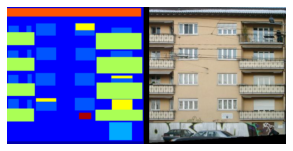

In [ ]:
files = get_tuple_files(path_base.parent)
ToTensor()(Resize(256)(ImageNTuple.create(files[0]))).show()

We leave `cmp_b0068` and `cmp_b0331` out of the training set because the authors used those ones as examples in the paper. We are going to do the same.

In [ ]:
valid_idx = L(files).itemgot(0).attrgot('stem').argwhere(eq('cmp_b0331'))
valid_idx += L(files).itemgot(0).attrgot('stem').argwhere(eq('cmp_b0068'))

Now we build our datablock with the labels as the `x`s and the `ImageNTuple` as the `y`s. We use 400 images which is what the authors used, as well as random jitter (in this case using fastai presizing).
Very important: we have to use nearest neighbors interpolation, since we have images that are labels.

In [ ]:
im_size = 256
facades = DataBlock(
                    blocks=(ImageBlock, ImageTupleBlock),
                    get_items=lambda x: get_tuple_files(x)[:402],
                    get_x=itemgetter(0),
                    splitter=IndexSplitter(valid_idx),
                    item_tfms=Resize(286, ResizeMethod.Squish, resamples=(Image.NEAREST, Image.NEAREST)),
                    batch_tfms=[Normalize.from_stats(0.5*torch.ones(3), 0.5*torch.ones(3)), 
                                *aug_transforms(size=im_size, mult=0.0, max_lighting=0, p_lighting=0, mode='nearest')],
                    )

In [ ]:
dls = facades.dataloaders(path_base.parent, bs=1, num_workers=2)
b = dls.one_batch()
test_eq(len(b), 2)
test_eq(len(b[1]), 2)
test_eq(b[1][0], b[0])

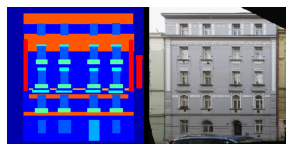

In [ ]:
dls.show_batch(b, figsize=[5,5])

## The loss
We are going to define the critic and the generator loss as well as functions to use as metrics during training.

### Generator Loss

In [ ]:
#export
def gen_bce_l1_loss(fake_pred, output, target, l1_weight=100, bce_weight=1):
    l1_loss = nn.L1Loss()(output[-1],target[-1])
    ones = fake_pred.new_ones(*fake_pred.shape)
    bce_loss= nn.BCEWithLogitsLoss()(fake_pred, ones)
    return bce_weight*bce_loss + l1_weight*l1_loss

def gen_bce_loss(learn, output, target):
    fake_pred = learn.model.critic(output)
    ones = fake_pred.new_ones(*fake_pred.shape)
    bce = nn.BCEWithLogitsLoss()(fake_pred, ones)
    return bce

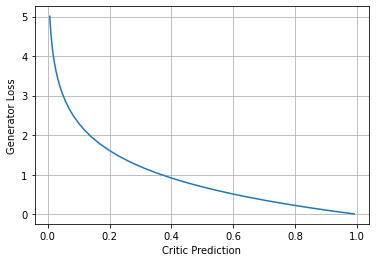

In [ ]:
x = torch.arange(-5, 5, step=0.2).unsqueeze(-1)
output = torch.ones(2, 1)
y = []
for xi in x: y.append(gen_bce_l1_loss(xi, output, output))
plt.figure(); plt.plot(nn.Sigmoid()(x),y)
plt.xlabel('Critic Prediction'); plt.ylabel('Generator Loss');plt.grid(True);

### Critic Loss

In [ ]:
#export
def crit_bce_loss(real_pred, fake_pred):
    ones  = real_pred.new_ones(*real_pred.shape)
    zeros = fake_pred.new_zeros(*fake_pred.shape)
    loss_neg = nn.BCEWithLogitsLoss()(fake_pred, zeros)
    loss_pos = nn.BCEWithLogitsLoss()(real_pred, ones)
    return (loss_neg + loss_pos)/2

def crit_real_bce(learn, real_pred, input):
    ones  = real_pred.new_ones(*real_pred.shape)
    rbce = nn.BCEWithLogitsLoss()(real_pred, ones)
    return rbce

def crit_fake_bce(learn, real_pred, input):
    fake = learn.model.generator(input).requires_grad_(False)
    fake_pred = learn.model.critic(fake)
    zeros = fake_pred.new_zeros(*fake_pred.shape)
    fbce = nn.BCEWithLogitsLoss()(fake_pred, zeros)
    return fbce

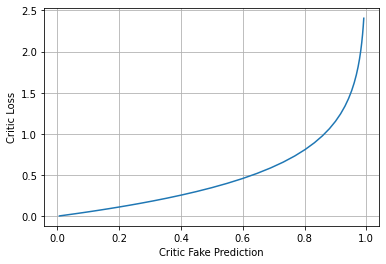

In [ ]:
x = torch.arange(-5, 5, step=0.2).unsqueeze(-1)
y = []
for xi in x: y.append(crit_bce_loss(Tensor([100]), xi))
plt.plot(nn.Sigmoid()(x),y)
plt.xlabel('Critic Fake Prediction'); plt.ylabel('Critic Loss'); plt.grid(True)

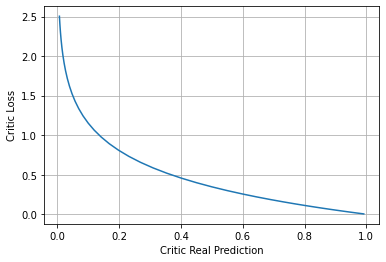

In [ ]:
x = torch.arange(-5, 5, step=0.2).unsqueeze(-1)
y = []
for xi in x: y.append(crit_bce_loss(xi, Tensor([-100])))
plt.plot(nn.Sigmoid()(x),y)
plt.xlabel('Critic Real Prediction'); plt.ylabel('Critic Loss'); plt.grid(True)

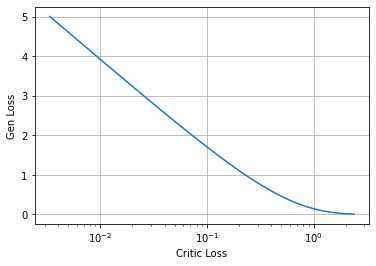

In [ ]:
x = torch.arange(-5, 5, step=0.2).unsqueeze(-1)
y_critic = []
y_gen = []
for xi in x:
    y_critic.append(crit_bce_loss(Tensor([100]), xi))
    y_gen.append(gen_bce_l1_loss(xi, torch.ones(2, 1), torch.ones(2, 1)))
plt.figure();plt.plot(y_critic,y_gen)
plt.xlabel('Critic Loss');plt.ylabel('Gen Loss');plt.xscale('log');plt.grid(True)

## The critic and the generator

### Critic
The authors tested different architecures for the critic, but the one that achieved the best performance was 70x70 PatchGAN. Each feature in the output of this architecure has a 70x70 receptive field.

In [ ]:
#export
def Patch70(n_channels):
    layers = []
    layers.append(ConvLayer(n_channels, 64, ks=4, stride=2, norm_type=None, bias=False,
                           act_cls=partial(nn.LeakyReLU, negative_slope=0.2, inplace=True)))
    layers.append(ConvLayer(64, 128, ks=4, stride=2, norm_type=NormType.Batch, bias=False,
                           act_cls=partial(nn.LeakyReLU, negative_slope=0.2, inplace=True)))
    layers.append(ConvLayer(128, 256, ks=4, stride=2, norm_type=NormType.Batch, bias=False,
                           act_cls=partial(nn.LeakyReLU, negative_slope=0.2, inplace=True)))
    layers.append(ConvLayer(256, 512, ks=4, stride=1, norm_type=NormType.Batch, bias=False,
                           act_cls=partial(nn.LeakyReLU, negative_slope=0.2, inplace=True)))
    layers.append(nn.Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1)))
    return nn.Sequential(*layers)

(1.4242089986801147, -0.8212226629257202)

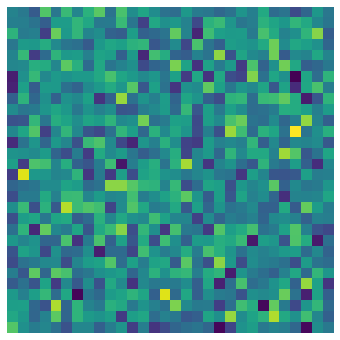

In [ ]:
x = 2*torch.rand(1,6,256,256)-1
cri = Patch70(6)
out = cri(x)
test_eq(out.shape, torch.Size([1,1,30,30]))
show_image(out[0], figsize=[6,6]);float(out.max()),float(out.min())

We can check that the receptive fields are 70x70 as we want

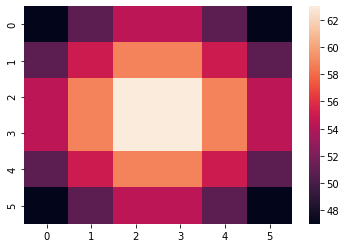

In [ ]:
rfs = receptive_fields(Patch70(1), 1, (64, 64))
sns.heatmap(rfs);

### Generator
The authors showed that a generator with a UNet sturcture produced the best results. If we read the paper's `section 6.3 Errata` we will discover that the original architecure had an extra layer that was not being used. The thing is that the thinest layer in the unet used batch normalization and since it was a 1x1 layer and the batch size was 1, the normalization was zeroing all the activations. In Pytorch, BatchNorm yields an error in this situation. We can skip that layer, as the authors suggest.

In [ ]:
#export
class UnetUpsample(Module):
    def __init__(self, ni, nout, hook, ks, padding, dropout=False):
        self.hook = hook
        self.upsample = ConvLayer(ni, nout, ks=ks, stride=2, norm_type=NormType.Batch,
                                  transpose=True, padding=padding, bias=False)
        if dropout:
            layers = list(self.upsample.children())
            layers.append(nn.Dropout(0.5))
            self.upsample = nn.Sequential(*layers)
    def forward(self, x): 
        return torch.cat([self.upsample(x), self.hook.stored], dim=1)

class CGenerator(SequentialEx):
    def __init__(self, n_channels, out_channels, enc_l=5):
        encoder = []
        encoder.append(ConvLayer(n_channels, 64, ks=4, stride=2, norm_type=None, bias=False,
                                 act_cls=partial(nn.LeakyReLU, negative_slope=0.2, inplace=True)))
        ni = 64
        for i in range(enc_l):
            nout = min(ni*2, 512)
            encoder.append(ConvLayer(ni, nout, ks=4, stride=2, norm_type=NormType.Batch, bias=False,
                                     act_cls=partial(nn.LeakyReLU, negative_slope=0.2, inplace=True)))
            ni = nout
        nout = min(ni*2, 512)
        encoder.append(ConvLayer(ni, nout, ks=4, stride=2, norm_type=NormType.Batch, bias=False, padding=1))# act_cls=None
        ni = nout
        hooks = hook_outputs(encoder[:-1])
        decoder = []
        for i, (l, h) in enumerate(zip(encoder[-2::-1], hooks[::-1])):
            nout = first(l.children()).out_channels
            ks = 4
            padding = 1 
            dropout = i<enc_l-3
            decoder.append(UnetUpsample(ni, nout, h, ks, padding, dropout=dropout))
            ni = 2*nout
        nout = out_channels
        decoder.append(ConvLayer(ni, nout, ks=4, stride=2, norm_type=NormType.Batch, transpose=True, padding=1, bias=True, act_cls=nn.Tanh))
        layers = encoder + decoder
        super().__init__(*layers)
    def forward(self, x):
        return super().forward(x)
            

We can inspect how many parameters the generator has

In [ ]:
g = CGenerator(3, 3, enc_l=5)
print(L(g.parameters()).map(Self.numel()).sum())

41830025


We can also check that the output is in the expected range and that it has a normal distribution if the input is normal

(0.0009999951580539346, 0.999985933303833)

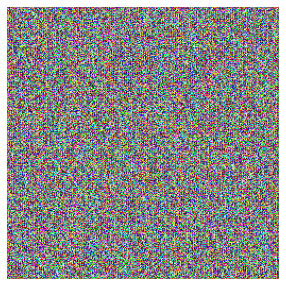

In [ ]:
g = g.cuda()
x = torch.randn(1, 3, im_size, im_size).cuda()
out = g(x)
test_eq(out.shape, torch.Size([1, 3, im_size, im_size]))
test_eq(out.max()<=1, True)
test_eq(out.max()>=-1, True)
TensorImage(out[0]*0.5+0.5).show()
float(torch.atanh(out).mean()), float(torch.atanh(out).std())

If the input is an image, the output should have some evidence of that

(0.0010000014444813132, 0.9999865293502808)

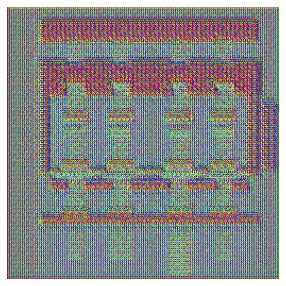

In [ ]:
x = b[0]
out = g(x)
test_eq(out.shape, torch.Size([1, 3, im_size, im_size]))
test_eq(out.max()<=1, True)
test_eq(out.max()>=-1, True)
TensorImage(out[0]*0.5+0.5).show()
float(torch.atanh(out).mean()), float(torch.atanh(out).std())

## Learning

We put everything together in a `GANLearner`.

It is very important to set the value `switch_eval=False`. If not, the generator will be in eval mode (the BatchNorm layers will behave differently) when the critic is being updated but it will be in trian mode during its SGD step. The same thing would happend for the critic. This leads to model collapse.

We use the optimization hyperparameters that the authors suggest.

Since we are using `FixedGANSwitcher` we need twice the number of iterations to reproduce the results.

In [ ]:
patch70_critic = Patch70(6)
critic = SiameseCritic(patch70_critic)
cgen = CGenerator(3, 3, enc_l=5)
cgen = ConditionalGenerator(cgen)
out = widgets.Output()
learn = GANLearner(
                   dls, cgen, critic,
                   partial(gen_bce_l1_loss, l1_weight=100, bce_weight=1),                   
                   crit_bce_loss,
                   switcher=FixedGANSwitcher(n_crit=1, n_gen=1),
                   metrics=[l1, GenMetric(gen_bce_loss), CriticMetric(crit_fake_bce), CriticMetric(crit_real_bce)],
                   opt_func = partial(Adam, mom=0.5, sqr_mom=0.999, wd=0,eps=1e-7),
                   cbs=[ProgressImage(out, figsize=(10,10), conditional=True)],
                   gen_first=False,
                   switch_eval=False)#
learn.recorder.train_metrics=True
learn.recorder.valid_metrics=False
out

Output()

In [ ]:
epochs = 400
learn.fit(epochs, lr=2e-4, wd=0)

epoch,train_loss,l1,gen_bce_loss,crit_fake_bce,crit_real_bce,gen_loss,crit_loss,time
0,22.586386,0.444717,2.580847,0.203905,0.264735,46.915890,0.268862,00:13
1,20.481554,0.385514,2.934002,0.138650,0.290037,41.386810,0.278906,00:12
2,20.201519,0.375420,2.630315,0.147635,0.254826,40.073158,0.260684,00:12
3,20.532356,0.381822,2.685161,0.141452,0.272733,40.767303,0.277344,00:13
4,20.128574,0.374044,2.788269,0.138759,0.260309,40.099552,0.261521,00:12
5,20.540501,0.382677,2.738109,0.134592,0.274200,40.923569,0.262855,00:12
6,20.981331,0.392099,2.877460,0.151022,0.269934,41.993568,0.283603,00:13
7,20.777658,0.387837,3.038377,0.117422,0.273317,41.741695,0.265735,00:13
8,20.466681,0.385468,3.015974,0.134805,0.276661,41.460690,0.265513,00:13
9,21.149145,0.389665,2.725138,0.127625,0.296982,41.607338,0.272892,00:11


In [ ]:
learn.show_results(max_n=2, ds_idx=1, figsize=(20,10))

In [ ]:
learn.show_results(max_n=2, ds_idx=1, figsize=(20,10))

Save the model if you want

In [ ]:
#learn.save('pix2pix_facades_200epochL100.pkl')

## And now full FastAI 

In [ ]:
critic = SiameseCritic(basic_critic(im_size, 6))
m = resnet34()
m = nn.Sequential(*list(m.children())[:-2])
cgen = DynamicUnet(m, 3, (256, 256))
cgen = ConditionalGenerator(cgen)
out = widgets.Output()
learn = GANLearner(
                   dls, cgen, critic,
                   partial(gen_bce_l1_loss, l1_weight=100, bce_weight=1),                   
                   crit_bce_loss,
                   switcher=FixedGANSwitcher(n_crit=1, n_gen=1),
                   metrics=[l1, GenMetric(gen_bce_loss), CriticMetric(crit_fake_bce), CriticMetric(crit_real_bce)],
                   opt_func = partial(Adam, mom=0.5, sqr_mom=0.999, wd=0,eps=1e-7),#Adam,#,,#,# #partial(SGD, mom=0.5)#
                   cbs=[ProgressImage(out, figsize=(10,10))],
                   gen_first=True,
                   switch_eval=False)#
learn.recorder.train_metrics=True
learn.recorder.valid_metrics=False
out

In [ ]:
epochs = 400
learn.fit(epochs, lr=2e-4, wd=0)

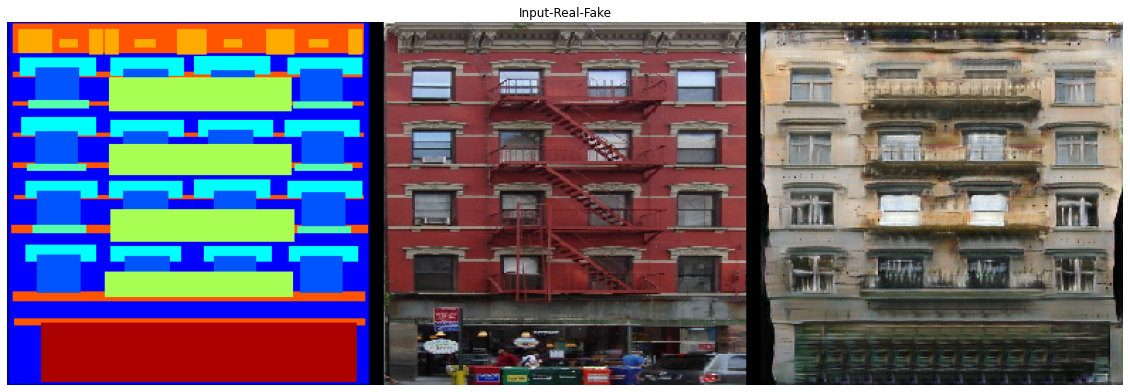

In [ ]:
learn.show_results(max_n=2, ds_idx=1, figsize=(20,10))

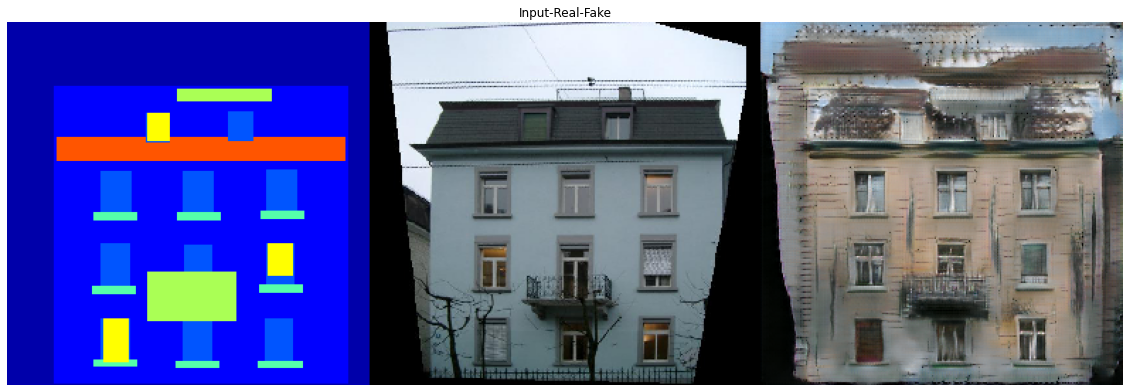

In [ ]:
learn.show_results(max_n=2, ds_idx=1, figsize=(20,10))

## Predicting

In [ ]:
@patch
def predict(self:GANLearner, item, rm_type_tfms=None, with_input=False):
    dl = self.dls.test_dl([item], rm_type_tfms=rm_type_tfms, num_workers=0)
    inp,preds,_,dec_preds = self.get_preds(dl=dl, with_input=True, with_decoded=True)
    i = getattr(self.dls, 'n_inp', -1)
    inp = (inp,) if i==1 else tuplify(inp)
    n_out = len(self.dls.tls) - i
    dec_preds = (dec_preds,) if n_out==1 else tuplify(dec_preds)
    dec = self.dls.decode_batch(inp + dec_preds)[0]
    dec_inp,dec_targ = map(detuplify, [dec[:i],dec[i:]])
    res = dec_targ,dec_preds[0],preds[0]
    if with_input: res = (dec_inp,) + res
    return res

In [ ]:
dl = learn.dls.test_dl([[0]])
first(dl)
learn.predict([0, 1])

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
test_files = get_test_files(path_base.parent)
ImageNTuple(learn.predict(test_files[0][0])[0]).show()
ImageNTuple(learn.predict(test_files[1][0])[0]).show()

TypeError: isinstance() arg 2 must be a type or tuple of types

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_isola2017image.ipynb.
Converted 02_heusel2017gans.ipynb.
Converted index.ipynb.
